# 风扇扇叶损坏检测

## 导入常用库

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 读取数据

In [3]:
data = pd.read_csv('res/Early_warning.csv',encoding='gb2312')            # data存储数据
data.head()

,风机叶片速度等级,风机轴承振动系数,风速功率,多组轴向秒级振动系数,风机页面是否开裂
0,10,2,3,2,0
1,4,6,9,10,1
2,3,5,8,7,0
3,8,6,9,6,1
4,5,4,2,4,0


## 透视表
- **data**：DataFrame
- **index**：根据index分组分类，Seq|str
- value：默认为data的全部列，可以指定只对某些列进行处理
- columns：对列名进行换名
- aggfunc：默认为mean，可以换成其他 str|list|dict
- margins:默认为False，是否汇总
---
- crosstab是pivot_table的一个特例
- groupby和pivot_table本质差不多，但是groupby不能汇总

In [18]:
# 汉字前加u，代表将编码转为utf-8
pd.pivot_table(data=data,index=data[u'风机页面是否开裂'],aggfunc={u'多组轴向秒级振动系数':['mean','min','max'],u'风速功率':['mean']})     # 必须有data 和 index

多组轴向秒级振动系数                     风速功率
                max      mean  min      mean
风机页面是否开裂                                    
0              10.0  4.518519  1.0  5.222222
1              10.0  7.576577  2.0  5.522523

## 热力图
- seaborn库中的heatmap
  - **data**：DataFrame，特征之间的关系使用df.corr()方法得到
  - annot：表示每一个格子显示关系的数字【即关系强度】
  - fmt：格子里显示数据的格式
  - cmap：颜色集
  - vmin,vamx：表示最右边关系的范围
  - xticklabels，yticklabels：表示x,y轴的标签

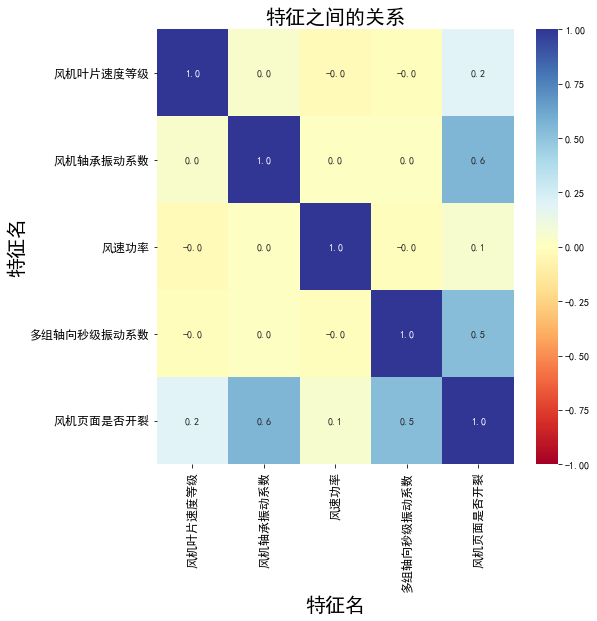

In [29]:
import seaborn as sns

x_ticks = []
y_ticks = []
new_data = data.corr()

plt.figure(figsize=(8,8))
ax = sns.heatmap(data=new_data,annot=True,fmt='0.1f',cmap=plt.cm.RdYlBu,vmax=1,vmin=-1,xticklabels=data.columns,yticklabels=data.columns)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_title(u"特征之间的关系",fontsize=20)
ax.set_xlabel(u'特征名',fontsize=20)
ax.set_ylabel(u'特征名',fontsize=20)
plt.show()

## 扇叶损害比例

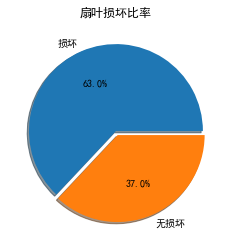

In [28]:
x = [len(data) - data[data.columns[-1]].sum(),data[data.columns[-1]].sum()]
plt.title('扇叶损坏比率')
plt.pie(x=x,labels=['损坏','无损坏'],explode=[0,0.05],shadow=True,autopct='%1.1f%%')
plt.show()

## 特征之间的可视化

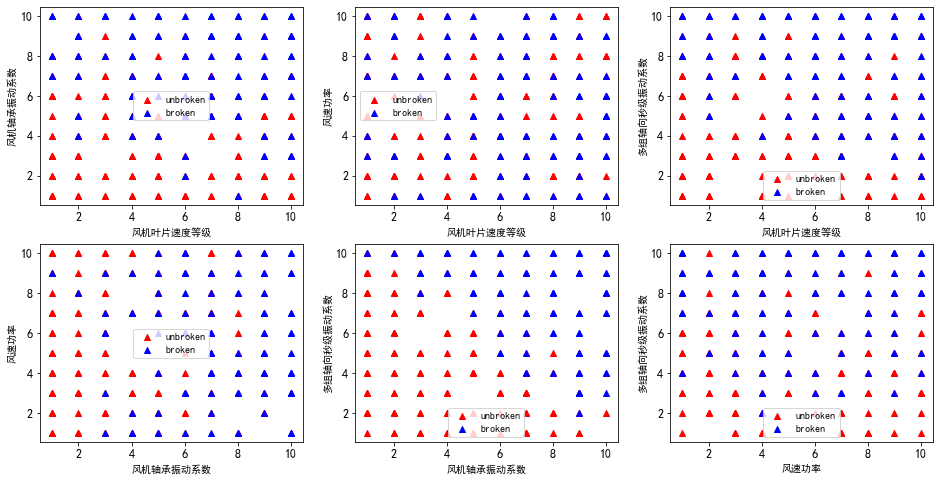

In [62]:
# 可视化
combination = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
pos = 1
color = 'rb'
label = ['unbroken','broken']
plt.figure(figsize=(16,8))
for index in combination:
    x = np.array(data[data.columns[index[0]]])
    y = np.array(data[data.columns[index[1]]])
    ax = plt.subplot(2,3,pos)
    pos+=1
    plt.xlabel(data.columns[index[0]])
    plt.xticks(fontsize=12)
    plt.ylabel(data.columns[index[1]])
    plt.yticks(fontsize=12)
    for i,c in zip(range(2),color):
        idx = np.where(i==data[data.columns[-1]])
        ax.scatter(x[idx],y[idx],c=c,label=label[i],marker='^')
    plt.legend(loc='best')
plt.show()

## 分类边界可视化

In [47]:
def classify(df:pd.DataFrame,columns:list,combination:list,clf,color:str,targetIndex:int,label:list,figsize=(16,8),step=0.02):
    plt.figure(figsize=figsize)
    x,y,pos=2,3,1
    for index in combination:
        ax = plt.subplot(x,y,pos)
        pos+=1
        # 得到ndarrar类型的数据
        train = np.array(df[[columns[index[0]],columns[index[1]]]])     # ndarray类型
        target = np.array(df[columns[targetIndex]])
        clf.fit(train,target)
        # 获取特征的最大最小值
        x_min,x_max = train[...,0].min()-1, train[...,0].max()+1        # 只有ndarray类型可以使用这种方法输出元素，list类型只有[slice]即切片类型，dataframe也是只有切片类型
        y_min,y_max = train[...,1].min()-1,  train[...,1].max()+1
        # 获取
        xx,yy = np.meshgrid(np.arange(x_min,x_max,step),np.arange(y_min,y_max,step))
        # 预测数据
        Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z,cmap=plt.cm.RdYlBu)          # 决策边界绘制
        # plt.pcolormesh(xx,yy,Z,cmap=plt.cm.Paired)        # 也是决策边界的绘画
        # 设置xy轴的标签
        plt.xlabel(columns[index[0]])
        plt.ylabel(columns[index[1]])
        # 对于每一种类的花单独画图
        for i, c in zip(range(len(color)), color):          # 画对应的颜色
            idx = np.where(target == i)                     # 返回target数组中 数据==i 的索引值，即返回一个数组，数组中全是值i的索引
            ax.scatter(train[idx, 0], train[idx, 1], c=c,cmap=plt.cm.RdYlBu,marker='^',label=label[i])
            plt.legend(loc='best')
    plt.show()

## 模型训练预测

### 数据分割

In [35]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_trian,y_test = train_test_split(data[data.columns[:4]],data[data.columns[-1]],test_size=0.5,random_state=3)

score =  0.9333333333333333


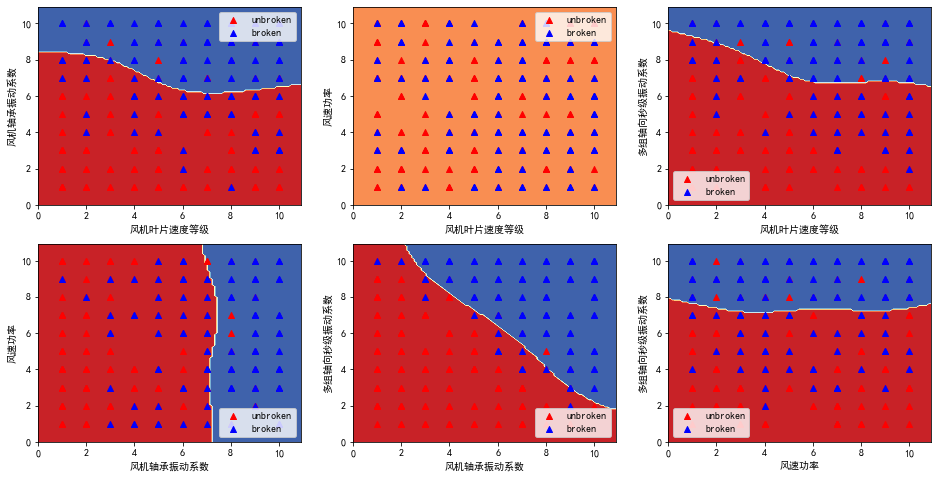

In [48]:
from sklearn import svm
from sklearn import metrics

clf = svm.SVC()
clf.fit(X=X_train,y=y_trian)
score = metrics.accuracy_score(y_true=y_test,y_pred=clf.predict(X_test))
print("score = ",score)

classify(data,data.columns,combination,svm.SVC(),color='rb',targetIndex=4,label=['unbroken','broken'],step=0.1)

score =  0.8733333333333333


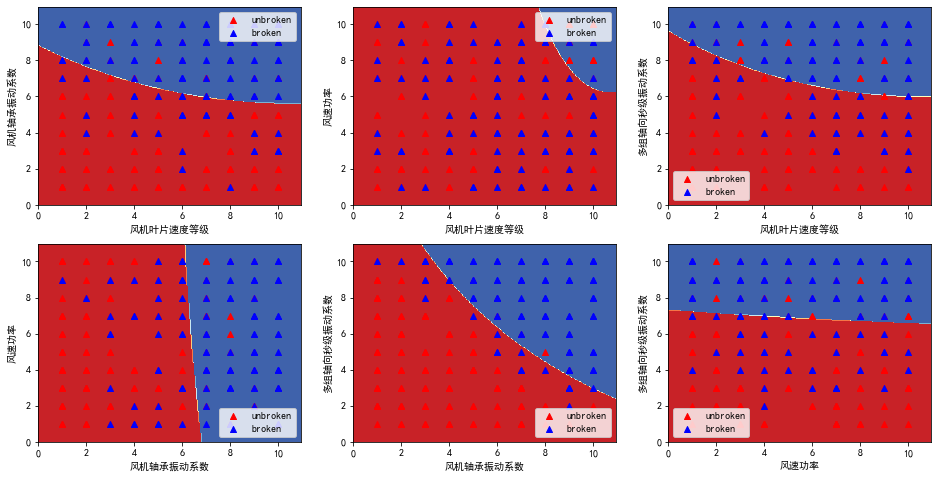

In [49]:
from sklearn import naive_bayes

clf = naive_bayes.GaussianNB()
clf.fit(X=X_train,y=y_trian)
score = metrics.accuracy_score(y_true=y_test,y_pred=clf.predict(X_test))
print("score = ",score)

classify(data,data.columns,combination,naive_bayes.GaussianNB(),color='rb',targetIndex=4,label=['unbroken','broken'],step=0.05)

score =  0.8466666666666667


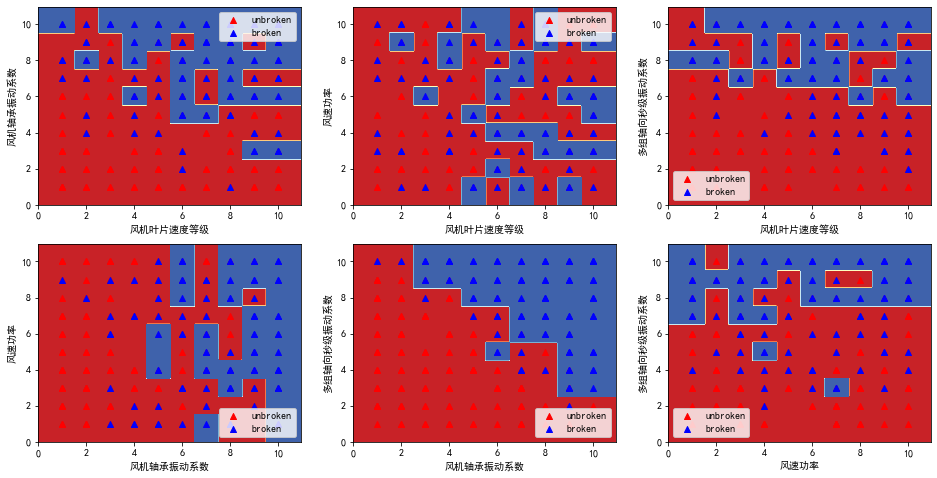

In [51]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X=X_train,y=y_trian)
score = metrics.accuracy_score(y_true=y_test,y_pred=clf.predict(X_test))
print("score = ",score)

classify(data,data.columns,combination,tree.DecisionTreeClassifier(),color='rb',targetIndex=4,label=['unbroken','broken'],step=0.05)

score =  0.88


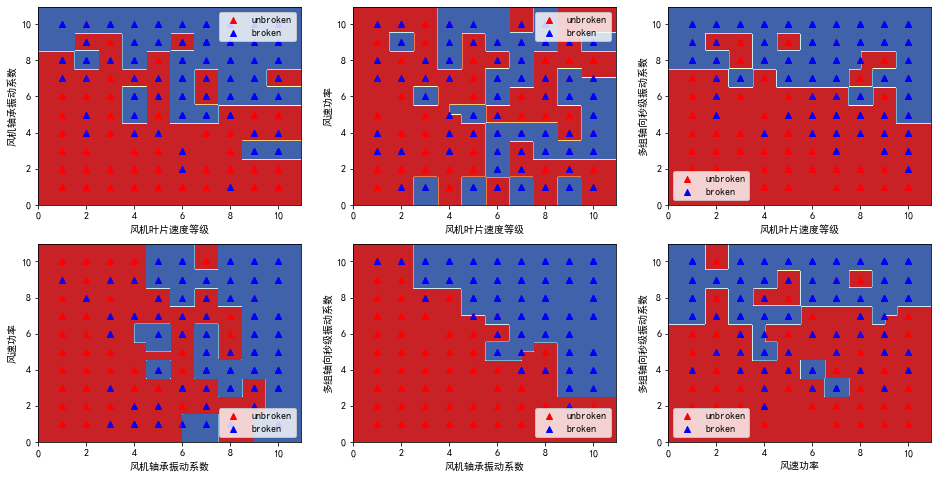

In [52]:
from sklearn import ensemble

clf = ensemble.RandomForestClassifier()
clf.fit(X=X_train,y=y_trian)
score = metrics.accuracy_score(y_true=y_test,y_pred=clf.predict(X_test))
print("score = ",score)

classify(data,data.columns,combination,ensemble.RandomForestClassifier(),color='rb',targetIndex=4,label=['unbroken','broken'],step=0.05)

score =  0.8933333333333333


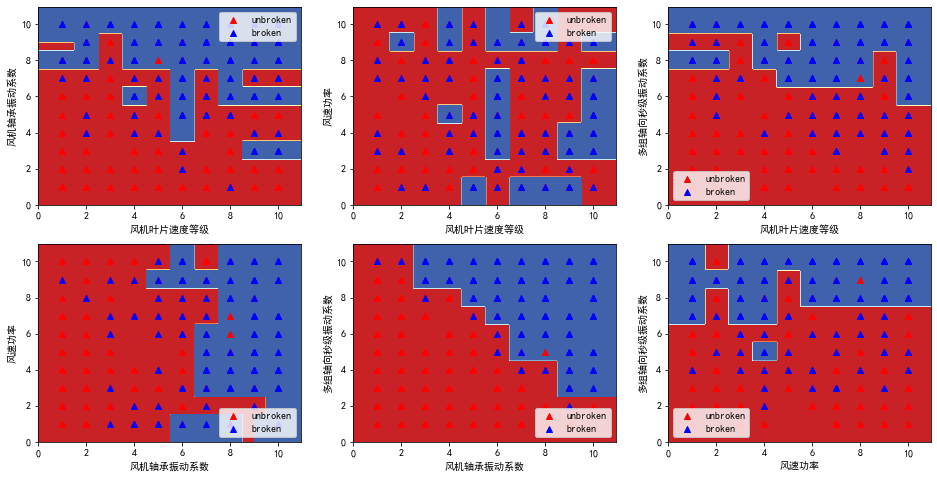

In [53]:
clf = ensemble.GradientBoostingClassifier()
clf.fit(X=X_train,y=y_trian)
score = metrics.accuracy_score(y_true=y_test,y_pred=clf.predict(X_test))
print("score = ",score)

classify(data,data.columns,combination,ensemble.GradientBoostingClassifier(),color='rb',targetIndex=4,label=['unbroken','broken'],step=0.05)